In [30]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle as pk
from smt.sampling_methods import LHS
from multiprocessing import Pool
import multiprocessing
# from my_model import mymf
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import cm
import matplotlib.colors
import pickle as pk
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import flopy.utils.binaryfile as bf
import shutil
from IPython.display import clear_output
from time import sleep
import h5py
from tqdm import tqdm
# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
from flopy.utils.util_array import read1d
mpl.rcParams['figure.figsize'] = (8, 8)
from TCP3d_model import mymf
from para_simu import simu
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))
exe_name_mf = '/Users/zitongzhou/Downloads/pymake/examples/mf2005'
exe_name_mt = '/Users/zitongzhou/Downloads/pymake/examples/mt3dms'
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rcParams['text.usetex'] = True
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version: 1.21.2
matplotlib version: 3.5.1
flopy version: 3.3.5


In [2]:
def simple_plot(c_map, title=''):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    if len(c_map) == 41:
        fig, axs = plt.subplots(1,1)
    #        axs.set_xlabel('x(m)')
    #        axs.set_ylabel('y(m)')
        # axs.set_xlim(0,Lx)
        # axs.set_ylim(0,Ly)
        c01map = axs.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
        fig.colorbar(c01map, ax=axs,shrink=0.62)
    else:
        fig, axs = plt.subplots(len(c_map)//3, 3, figsize=(7, 2.5))
        axs = axs.flat
        for i, ax in enumerate(axs):
            # ax.set_xlim(0,Lx)
            # ax.set_ylim(0,Ly)
            c01map = ax.imshow(c_map[i], cmap='jet', interpolation='nearest',
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      vmin=c_map[i].min(), vmax = c_map[i].max(),
                      origin='lower')
            ax.set_axis_off()
            v1 = np.linspace(np.min(c_map[i]),np.max(c_map[i]), 5, endpoint=True)
            fig.colorbar(c01map, ax=ax, fraction=0.021, pad=0.04,ticks=v1,)

    plt.suptitle(title)
    name = title + '.pdf'
    plt.tight_layout()
#         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
    plt.show()
    return

In [16]:
with h5py.File('/Volumes/Transcend/Desktop/reactive_inverse/AR_dataset_950.hdf5', 'r') as file:
    AR_input = np.asarray(file['input'])
    AR_output = np.asarray(file['output'])
print('input shape: ',AR_input.shape, '\noutput shape: ', AR_output.shape)

input shape:  (9500, 3, 6, 41, 81) 
output shape:  (9500, 2, 6, 41, 81)


In [17]:
n_train = 8000
n_test = 1500
x_test = AR_input[n_train: n_train+n_test]
y_test = AR_output[n_train: n_train+n_test]
del AR_input, AR_output

In [22]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torchvision.transforms as T
import torch.nn.functional as F
from torch.distributions import Gamma
"""
Convolutional Dense Encoder-Decoder Networks

Reference:
    https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py

Yinhao Zhu
Dec 21, 2017
Dec 30, 2017
Jan 03, 2018

Shaoxing Mo
May 07, 2019

Zitong Zhou
Feb 18, 2021
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class _DenseLayer(nn.Sequential):
    # bottleneck layer, bn_size: bottleneck size
    def __init__(self, in_features, growth_rate, drop_rate=0, bn_size=4,
                 bottleneck=False):
        # detect if the input features are more than bn_size x k,
        # if yes, use bottleneck -- not much memory gain, but lose one relu
        # I disabled the bottleneck for current implementation
        super(_DenseLayer, self).__init__()
        if bottleneck and in_features > bn_size * growth_rate:
            self.add_module('norm1', nn.BatchNorm3d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv3d(in_features, bn_size *
                            growth_rate, kernel_size=1, stride=1, bias=False))
            self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv3d(bn_size * growth_rate, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        else:
            self.add_module('norm1', nn.BatchNorm3d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv3d(in_features, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        y = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            y = F.dropout3d(y, p=self.drop_rate, training=self.training)
        z = torch.cat([x, y], 1)
        return z


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, in_features, growth_rate, drop_rate,
                 bn_size=4, bottleneck=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(in_features + i * growth_rate, growth_rate,
                                drop_rate=drop_rate, bn_size=bn_size,
                                bottleneck=bottleneck)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, in_features, out_features, encoding=True, drop_rate=0.,
                 last=False, out_channels=3, outsize_even=True):
        super(_Transition, self).__init__()
        self.add_module('norm1', nn.BatchNorm3d(in_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        if encoding:
            # reduce feature maps; half image size (input feature size is even)
            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv3d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout3d(p=drop_rate))
            self.add_module('norm2', nn.BatchNorm3d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv3d(out_features, out_features,
                                              kernel_size=3, stride=2,
                                              padding=1, bias=False))
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout3d(p=drop_rate))
        else:
            # decoding, transition up
            if last:
                ks = 6 if outsize_even else 5
                out_convt = nn.ConvTranspose3d(out_features, out_channels,
                                kernel_size=[2,ks,ks], stride=2, padding=[0,2,2],
                                output_padding=[0,0,0], bias=False)
            else:
                out_convt = nn.ConvTranspose3d(
                    out_features, out_features, kernel_size=3, stride=2,
                    padding=1, output_padding=0, bias=False)

            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv3d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout3d(p=drop_rate))

            self.add_module('norm2', nn.BatchNorm3d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('convT2', out_convt)
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout3d(p=drop_rate))

class DenseED(nn.Module):
    def __init__(self, in_channels, out_channels, blocks, growth_rate=16,
                 num_init_features=64, bn_size=4, drop_rate=0, outsize_even=False,
                 bottleneck=False):
        """
        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            blocks: list (of odd size) of integers
            growth_rate (int): K
            num_init_features (int): the number of feature maps after the first
                conv layer
            bn_size: bottleneck size for number of feature maps (not useful...)
            bottleneck (bool): use bottleneck for dense block or not
            drop_rate (float): dropout rate
            outsize_even (bool): if the output size is even or odd (e.g.
                65 x 65 is odd, 64 x 64 is even)

        """
        super(DenseED, self).__init__()
        self.out_channels = out_channels

        if len(blocks) > 1 and len(blocks) % 2 == 0:
            ValueError('length of blocks must be an odd number, but got {}'
                       .format(len(blocks)))
        enc_block_layers = blocks[: len(blocks) // 2]
        dec_block_layers = blocks[len(blocks) // 2:]
        self.features = nn.Sequential()
        # First convolution ================
        # only conv, half image size
        self.features.add_module('in_conv',
                    nn.Conv3d(in_channels, num_init_features,
                            kernel_size=[3,7,7], stride=2, padding=[1,3,3], bias=False))

        # Encoding / transition down ================
        # dense block --> encoding --> dense block --> encoding
        num_features = num_init_features
        for i, num_layers in enumerate(enc_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('encblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=True, drop_rate=drop_rate)
            self.features.add_module('down%d' % (i + 1), trans)
            num_features = num_features // 2

        # Decoding / transition up ==============
        # dense block --> decoding --> dense block --> decoding --> dense block
        # if len(dec_block_layers) - len(enc_block_layers) == 1:
        for i, num_layers in enumerate(dec_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('decblock%d' % (i + 1), block)
            num_features += num_layers * growth_rate

            # if this is the last decoding layer is the output layer
            last_layer = True if i == len(dec_block_layers) - 1 else False

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=False, drop_rate=drop_rate,
                                last=last_layer, out_channels=out_channels,
                                outsize_even=outsize_even)
            self.features.add_module('up%d' % (i + 1), trans)
            num_features = num_features // 2

    def forward(self, x):
        y = self.features(x)

        # #set the source point conc to be constant if there's release
        # nonzero_source = torch.nonzero(x[:,2,:,:,:])
        # # print('nonzero ',nonzero_source)
        # if len(nonzero_source) > 0:
        #     for non in nonzero_source:
        #         y[non[0],0,non[1],non[2],non[3]] = x[non[0],2,non[1],non[2],non[3]]
                
        # use the softplus activation for concentration and head
        y = F.softplus(y.clone(), beta=5)

        # CAUTION: if the last channel is pressure, 
        # use the sigmoid activation for pressure
        # y[:,self.out_channels-1] = torch.sigmoid(y[:,self.out_channels-1])

        return y

    def _num_parameters_convlayers(self):
        n_params, n_conv_layers = 0, 0
        for name, param in self.named_parameters():
            if 'conv' in name:
                n_conv_layers += 1
            n_params += param.numel()
        return n_params, n_conv_layers

    def _count_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            print(name)
            print(param.size())
            print(param.numel())
            n_params += param.numel()
            print('num of parameters so far: {}'.format(n_params))

    def reset_parameters(self, verbose=False):
        for module in self.modules():
            # pass self, otherwise infinite loop
            if isinstance(module, self.__class__):
                continue
            if 'reset_parameters' in dir(module):
                if callable(module.reset_parameters):
                    module.reset_parameters()
                    if verbose:
                        print("Reset parameters in {}".format(module))
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.cpu().detach().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))
        

def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    eps = torch.randn_like(std)
    #randn_like: Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
    #return: random gaussian sample from distribution with mu and exp(logvar/2)
    return mu + eps*std


class DenseResidualBlock(nn.Module):
    """
    The core module of paper: (Residual Dense Network for Image Super-Resolution, CVPR 18)
    """

    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        def block(in_features, non_linearity=True):
            layers = [nn.BatchNorm3d(in_features)]
            layers += [nn.ReLU(inplace=True)]
            layers += [nn.Conv3d(in_features, filters, 3, 1, 1, bias=True)] # does not change state size
            return nn.Sequential(*layers)

        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters, non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x


class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), DenseResidualBlock(filters), DenseResidualBlock(filters)#, DenseResidualBlock(filters)
        )

    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x

class Encoder(nn.Module):
    def __init__(self, inchannels=1, outchannels=2, filters=48, num_res_blocks=1):
        super(Encoder, self).__init__()
        # input size, inchannels x 6 x 41 x 81
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=2, padding=1)
        # state size. filters x 3 x 21 x 41
        self.res_blocks = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        # state size. filters x 3 x 21 x 41
        self.trans = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Conv3d(filters, filters, kernel_size=3, stride=2, padding=1),
        )
        # state size. filters x 2 x 11 x 21
        self.mu = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.
        self.logvar = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.

    def forward(self, img):
        # img: inchannels x 6 x 41 x 81
        out1 = self.conv1(img)        # filters x 3 x 21 x 41
        out2 = self.res_blocks(out1)   # filters x 3 x 21 x 41
        out3 = self.trans(out2)        # filters x 2 x 11 x 21

        mu, logvar = self.mu(out3), self.logvar(out3)
        z = reparameterization(mu, logvar) # latent dimension: outchannels x 2 x 11 x 21
        return z

    def _n_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params
                
class Decoder(nn.Module):
    def __init__(self, inchannels=2, outchannels=1, filters=48, num_res_blocks=1,num_upsample=2):
        super(Decoder, self).__init__()

        # First layer. input size, inchannels x 2 x 8 x 16
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=1, padding=1)

        # state size. filters x 2 x 8 x 16
        # Residual blocks
        self.res_block1 = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks+1)])
        self.transup1 = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(4, 21, 41), mode='nearest'),
            nn.Conv3d(filters, filters, kernel_size=3, stride=1, padding=1), #does not change state size
        )
        self.res_block2 = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        self.transup2 = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(8, 41, 81), mode='nearest'),
            nn.Conv3d(filters, outchannels, kernel_size=3, stride=1, padding=(0,1,1)), # reduce the first dimension by 2
        )


    def forward(self, z):
        # x: in_channels x 2 x 8 x 16
        out1 = self.conv1(z)          # filters x 2 x 8 x 16
        out2 = self.res_block1(out1)   # filters x 2 x 8 x 16
        out = torch.add(out1, out2)   # filters x 2 x 8 x 16
        out3 = self.transup1(out)      # filters x 4 x 16 x 32
        out4 = self.res_block2(out3)   # filters x 4 x 16 x 32

        img = self.transup2(out4)     # outchannels x 6 x 32 x 64

        return img

    def _n_parameters(self):
        n_params= 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params
    
    
'''Load the CAAE model first'''
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
n_train = 23000
batch_size = 64
n_epochs = 50
lr = 0.0002 ## adam learning rate
lw = 0.01 ## "adversarial loss weight"

current_dir = "/Volumes/Transcend/Desktop/reactive_inverse/CAAE/"
date = 'experiments/Feb_14_CAAE3D'
exp_dir = current_dir + date + "/N{}_Bts{}_Eps{}_lr{}_lw{}".\
    format(n_train, batch_size, n_epochs, lr, lw)

output_dir = exp_dir + "/predictions"
model_dir = exp_dir

nf, d, h, w = 2, 2, 11, 21

# Initialize encoder
encoder = Encoder(outchannels=nf)
encoder.load_state_dict(torch.load(model_dir + '/AAE_encoder_epoch{}.pth'.format(n_epochs), map_location=torch.device('cpu')))
if cuda:
    encoder.cuda()

encoder.eval()

# Initialize decoder
decoder = Decoder(inchannels=nf)
decoder.load_state_dict(torch.load(model_dir + '/AAE_decoder_epoch{}.pth'.format(n_epochs), map_location=torch.device('cpu')))
if cuda:
    decoder.cuda()

decoder.eval()

Decoder(
  (conv1): Conv3d(2, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (res_block1): Sequential(
    (0): ResidualInResidualDenseBlock(
      (dense_blocks): Sequential(
        (0): DenseResidualBlock(
          (b1): Sequential(
            (0): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (b2): Sequential(
            (0): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv3d(96, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (b3): Sequential(
            (0): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv3d(144, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), paddin

In [57]:
np.random.seed(888)
y_wel = np.array([6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34])# #np.random.randint(low = 5, high = 35, size = 20)
x_wel = np.array([1, 1, 1, 1, 1, 
         7, 7, 7, 7, 7,
         13, 13, 13, 13, 13,
         20, 20, 20, 20, 20])# #np.random.randint(low = 0, high = 25, size = 20)
wells = {i: [y_wel[i], x_wel[i]] for i in range(len(y_wel))}
n_test = 1500
N = n_test//10
x = [np.unravel_index(x_test[ind*10][2].argmax(), x_test[ind*10][2].shape) for ind in range(N)]
q = [[np.max(x_test[10*i+j,2,:,:,:]) for j in range(5)] for i in range(N)]


In [60]:
all_kd = [x_test[i,1,:] for i in np.arange(0, 1500, 10)]
all_kd = np.expand_dims(np.asarray(all_kd), axis=1)
recon_kds = []

for sim in range(N):
    encoder.eval
    kd_latent = encoder(torch.tensor(np.expand_dims(all_kd[sim], axis=1)))
    decoder.eval
    kd_recon = to_numpy(decoder(kd_latent).reshape(-1, 6, 41, 81))[0]
    
    welspd = []
    for i in range(5):
        welspd.append([3, x[sim][1], x[sim][2], q[sim][i], -1])
    welspd.append([3, x[sim][1], x[sim][2], 0, -1])
    
    hf =  h5py.File('/Volumes/Transcend/Desktop/reactive_inverse/Recon_simu_inputs/input_{}.hdf5'.format(sim), 'w')
    hf.create_dataset('kd', data = kd_recon, dtype ='f', compression = 'gzip')
    hf.create_dataset('welspd', data = welspd, dtype ='f', compression = 'gzip')
    hf.close()

In [20]:
y_test_recon = []
for i in range(150):
    hf = 
    file = '/Users/ztzhou/Desktop/Recon_simu_outputs/output_{}.hdf5'.format(i)
    f =  h5py.File(file, 'r')
    conc = np.array(f['concentration'])
    conc[conc<0] = 0
    head = np.array(f['head'])
    f.close()
    assert len(conc) == 10
    for i in range(len(conc)):
        y_test_recon.append([conc[i],head])
    

In [63]:
output = []
output_recon = []
y_test = np.array(y_test)
y_test_recon=np.array(y_test_recon)
for i in range(150):
    output.append(
        list(y_test[i*10:i*10+10,0,:,:,:]) + list([y_test[i*10, 1, :,:,:]])
    )
    output_recon.append(
        list(y_test_recon[i*10:i*10+10,0,:,:,:]) + list([y_test_recon[i*10, 1, :,:,:]])
    )

output = np.asarray(output)
output_recon = np.asarray(output_recon)

In [68]:
output.shape

(150, 11, 6, 41, 81)

In [67]:
from sklearn.metrics import r2_score 

R_square = r2_score(output.reshape((150, -1)), output_recon.reshape((150, -1))) 
print('Coefficient of Determination', R_square) 

Coefficient of Determination 0.9623039532896295


In [33]:
## make autoregressive dataset: conc[t] + S[t] + kd ----> conc[t+1] + head, 
## skip the file that does not have the corresponding output file, or the output
## file is not complete.
AR_input = []
AR_output = []
problematic_conc = []
dir = os.listdir('/Users/ztzhou/Desktop/Recon_simu_outputs/')
os.chdir('/Users/ztzhou/Desktop/Recon_simu_outputs')

N_simu = 150
n_data = 0
file_ind = 0
file_inds = []
pbar = tqdm(total=N_simu)
while n_data < N_simu:
    file_ind += 1
    output_name = dir[file_ind-1]
    try:
        f = h5py.File(output_name, "r")
    except:
        continue
    ## output_name[7:] includes the index of the output file: 275.hdf5
    file_inds.append(output_name[7:])
    input_name = '/Users/ztzhou/Desktop/Recon_simu_inputs/input_' + output_name[7:]
    ## input: kd(6, 41, 81), welspd(5,[5]), [5]: loc+conc+type 
    input_file =  h5py.File(input_name, 'r')
    kd = np.array(input_file['kd'])
    welspd = np.array(input_file['welspd'])
    input_file.close()

    conc = np.array(f['concentration'])
    conc[conc<0] = 0
    head = np.array(f['head'])
    f.close()
    ## S: release for 5 steps
    if len(conc) != 10:
        problematic_conc.append(output_name[7:])
    else:
        conc = np.concatenate((np.zeros((1, 6, 41, 81)), conc), axis=0)
        S = np.zeros((len(conc)-1, 6, 41, 81))
        for i in range(len(welspd)-1):
            S[i, int(welspd[i,0]), int(welspd[i,1]), int(welspd[i,2])] = welspd[i,3]
        for i in range(len(conc)-1):
            AR_input.append([conc[i], kd, S[i]])
            AR_output.append([conc[i+1], head])
    n_data += 1
    pbar.update(1)

pbar.close()
print('\n',len(AR_input))
print(problematic_conc)

100%|████████████████████████████████████████| 150/150 [00:01<00:00, 126.98it/s]


 1500
[]


In [34]:
## save AR_input and AR_output in hdf5 file
hf =  h5py.File('/Users/ztzhou/Desktop/fake_AR_dataset_{}.hdf5'.format(str(N_simu)), 'w')
hf.create_dataset('fake_input', data = AR_input, dtype ='f', compression = 'gzip')
hf.create_dataset('fake_output', data = AR_output, dtype ='f', compression = 'gzip')
# hf.create_dataset('file_inds', data = file_inds, dtype='f', compression = 'gzip')
hf.close()

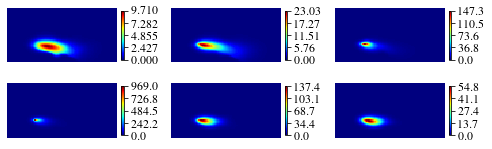

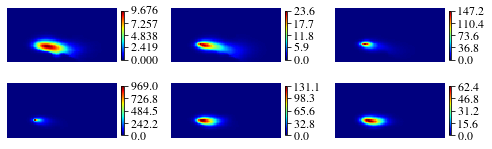

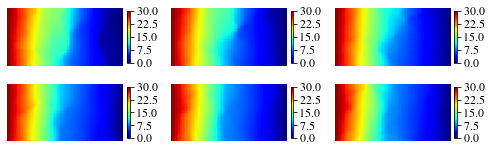

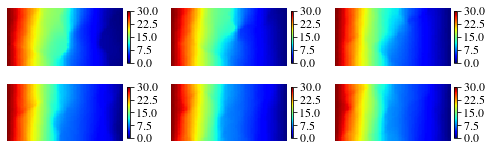

In [23]:
simple_plot(y_test_recon[0][0])
simple_plot(y_test[0][0])

simple_plot(y_test_recon[0][1])
simple_plot(y_test[0][1])
